In [1]:
import os
import json
import numpy as np
import pandas as pd
import pyarrow as pa
from pandas.io.json import json_normalize
import cryptography
import re
from cryptography.fernet import Fernet
import bs4
from nltk.tokenize import word_tokenize
import pickle

In [157]:
#rather than looping through everything, break it down and slowly go through each item
word_dict = {}
# Not included as all their files seem to be empty or they have no enrichment: 
    #4/5, 4/6, 4/13, 4/14, 4/15, 4/31, 5/13, 5/14, 5/15, 5/16, 5/17, 5/18, 7/4, 7/5, 7/6
date_batches = [['2019-04-22','2019-04-23','2019-04-24','2019-04-25','2019-04-26','2019-04-27','2019-04-28','2019-04-29'],
                ['2019-04-11','2019-04-12','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21'],
                ['2019-04-30','2019-05-01','2019-05-02','2019-05-03','2019-05-04'],
                ['2019-05-05','2019-05-06','2019-05-07','2019-05-08','2019-05-09','2019-05-10','2019-05-11','2019-05-12'],
                ['2019-05-19','2019-05-20'],
                ['2019-05-21','2019-05-22','2019-05-23','2019-05-24','2019-05-25','2019-05-26','2019-05-27','2019-05-28'],
                ['2019-05-29','2019-05-30','2019-05-31','2019-06-01','2019-06-02','2019-06-03','2019-06-04','2019-06-05'],
                ['2019-06-06','2019-06-07','2019-06-08','2019-06-09','2019-06-10','2019-06-11','2019-06-12','2019-06-13']]
dates = date_batches[0]+date_batches[1]+date_batches[2]+date_batches[3]+date_batches[4]+date_batches[5]+date_batches[6]+
    date_batches[7] 
#'2019-04-12','2019-04-16','2019-04-17','2019-04-18','2019-04-19','2019-04-20','2019-04-21]
indicators = []
for date in dates:
    files = os.listdir('/data/data/'+date+'/enrichment/fetch_page')
    for j in range(len(files)):
        with open('/data/data/'+date+'/enrichment/fetch_page/'+files[j]) as d:
            r = json.load(d)
            try:
                df = json_normalize(r['data'])
            except:
                break
        try:
            df = df[df['status_code'] == 200].reset_index(drop=True)
        except:
            df = df[df['success']]
        #not worrying about labels right now
        html_str = df['page_content'].copy()
        
        for i in range(len(html_str)):
            if df.loc[i,'indicator'] in indicators:
                continue
            else:
                indicators.append(df.loc[i, 'indicator'])
            key = bytes( df.loc[i,'encryption_key'],encoding = 'UTF-8')
            f = Fernet(key) #all rows of this df share this key
            #decrypt string
            text = f.decrypt(bytes(html_str[i],encoding='UTF-8'))
            #clean out html
            text = text.decode('utf8')
            #soup = bs4.BeautifulSoup(text,'lxml',from_encoding='utf8') #some JS may not get cleared 
           # print('check3')
            #text = soup.prettify()
            #print(text[:25])
           # print('check4')
            #remove numbers and make lowercase
            #text = re.sub(r'[0-9_\W]+',' ',text).lower()
           # print('check5')
            #tokenize
            text = re.sub('&quot;','\'',text)
            text = re.sub('&amp;','&',text)
            toks = re.split(r'[\s,:;{}\(\)<>\/�]+',text.lower())#.split()#word_tokenize(text.lower())
            print(toks[5:10])
            toks = set(toks)
          #  print('check6')
            #tups = list(zip(toks,[1]*len(toks)))
            for t in toks:
                if t in word_dict.keys() and t != '':
                    word_dict[t] = word_dict.get(t) + 1
                    #print(t)
                else:
                    word_dict[t] = 1
            #add to set
        print(len(word_dict))
         #end of for
    #end of for
    print('------------'+date+'---------------')
#end of for


           
            

['head', 'meta', 'name="viewport"', 'content="width=device-width', 'initial-scale=1']
['meta', 'name="viewport"', 'content="width=device-width', 'initial-scale=1"', 'meta']
['ie', '9]', 'html', 'class="no-js', 'lt-ie9"']
['header', 'footer', '--', '!doctype', 'html']
['id="facebook"', 'class="no_js"', 'head', 'meta', 'charset="utf-8"']
['meta', 'charset="utf-8"', 'title', 'en', 'son']
['itemtype="http', 'schema.org', 'webpage"', 'lang="el"', 'head']
['ie', '7', ']', 'html', 'lang="en-us"']
['lang="en"', 'head', 'base', 'href="', '"']
['ru', 'flexwrap"', 'lang="ru"', '!--', 'x-request-id']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'title', 'marketwatch', 'stock', 'market']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['ie', '7', ']', 'html', 'class="ie6"']
42086
['data-locale="en-us"', 'head', 'meta', 'name="viewport"', 'content="width=device-width']
['head', 'meta', 'charset

['title', 'filehippo.com', '-', 'download', 'free']
292745
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['lang="en-us"', 'head', 'title', 'office', '365']
['itemtype="http', 'schema.org', 'webpage"', 'lang="ru"', 'head']
['class="no-js"', 'data-device-type="dedicated"', 'head', 'title', 'денежные']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['head', 'meta', 'charset="utf-8"', 'title', 'mayo']
['xmlns', 'og="http', 'opengraphprotocol.org', 'schema', '"']
['8888', '8888', '.88', '8888', '8888']
['itemtype="http', 'schema.org', 'webpage"', 'lang="ru"', 'head']
['head', 'script', 'type="text', 'javascript"', 'window.nreum||']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['class="no-js', 'lang--en-us"', 'data-locale="en-us"', 'data-domain="ccleaner.com"', 'head']
['www.w3.org', '1999', 'xhtml"', 'lang="en"', 'head']
['head', '!--[if', 'ie]', 'meta', 'http-equiv="x-ua-compatible"'

['ie', '7]', 'html', 'lang="en-us"', 'class="lt-ie11']
['b-pw-1280', 'b-reith-sans-font"', 'head', 'meta', 'http-equiv="content-type"']
['7]', 'html', 'class="iem7"', 'lang="fa"', 'dir="rtl"']
['dir="ltr"', 'lang="ru"', 'data-status-code="200"', 'head', 'script']
['dir="ltr"', 'head', 'meta', 'charset="utf-8"', 'meta']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['8]', 'html', 'xmlns="http', 'www.w3.org', '1999']
579782
['class="core-ux"', 'data-app="feedpager"', 'data-env="prod"', 'head', 'link']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml+rdfa', '1.0', 'en"']
['head', '!--', 'encoding', '--', 'meta']
['lang="en-us"', 'prefix="og', 'http', 'ogp.me', 'ns#']
['head', 'title', 'homepage', '|', 'wiley']
['meta', 'name="title"', 'content="employees\'', 'provident', 'fund']
[]
['6]', 'html', 'class="ie', 'lt-ie8"', '![endif]--']
['lang="en"', 'head', 'meta', 'charset="utf-8"', 'meta']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="alexaverifyi

['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['fallback-fonts"', 'lang="en-us"', 'head', 'meta', 'http-equiv="x-ua-compatible"']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['head', 'meta', 'http-equiv=content-type', 'content="text', 'html']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'title']
['head', 'title', 'gma', 'network', 'portal']
774089
['i-ua_css_standart', 'i-ua_browser_msie', 'i-ua_browser_desktop', 'i-ua_browser_msie11', 'i-ua_platform_windows"']
['http', 'ogp.me', 'ns#', 'fb', 'http']
['ie', '8]', 'html', 'lang="en"', '![endif]--']
['class="no-svg', 'no-js"', 'dir="ltr"', 'head', 'title']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['"', 'lang="en"', 'id="lang_en"', 'head', 'meta']
['xml', 'lang="en"', 'xmlns="http', 'www.w3.org', '1999']
['class="no-js"', 'head', 'meta', 'http-equiv="content-type"', 'content="text']
['meta', 'http-equiv="content-type"', 'content="text', 'html', '&#32']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-

['xmlns', 'og="http', 'ogp.me', 'ns#"', 'xmlns']
['lang="en-us"', 'prefix="og', 'http', 'ogp.me', 'ns#"']
990587
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['lang="en"', 'head', 'meta', 'http-equiv="content-type"', 'content="text']
['head', 'meta', 'charset="utf-8"', 'title', 'آپارات']
['content="noindex', 'nofollow"', 'script', 'src="https', 'www.google.com']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'h="http']
['class="no-js', 'not-logged-in', 'client-root"', 'head', 'meta']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['no-js', '"', 'lang="en"', 'prefix="og', 'http']
['fb="http', 'ogp.me', 'ns', 'fb#"', 'itemtype="http']
['http', 'ogp.me', 'ns#', 'fb', 'http']
['og="http', 'opengraphprotocol.org', 'schema', '"', 'xmlns']
['ie', '9]', 'html', 'class="lte-ie8"', 'lang="en"']
['layoutversion="3.1.0"', 'layoutsupportheaderversion="4.5.0"', 'head', 'meta', 'http-equiv="x-ua-compatible"']
['class="main', 'main-page', '"', 'head', 'meta']
['lang="en"', 'x

['\x01\x00�', '\x01\x00\x05\x00\x00\x00\x00�\x00\x00\x01\x00\x00\x00\x00@\x01\x00\x00@\x02\x00\x00@\x02\x00d\x03\x00\x00�g\x00\x00\x06\x00\x00\x00\x00�\x00\x00q�td\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x00\x00\x00\x04\x00\x00\x00', '�����-�\x04�l��\x1b�\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00g�f\x08g�f\x10g�f\x18g�f', 'g�f', 'g�f0g�f8g�f@g�fhg�fpg�fxg�f`g�fhg�fpg�f\x10@-�']
1140682
1140682
['bin', 'curl"', 'bbdira="', 'usr', 'bin']
1140716
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
1140718
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
1140726
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
1141403
1141403
['']
['']
['']
['']
1141404
[']\x17y�*&�', '�k���', '��\x029xӝ', '��f�\x1b�fi�-', '!1z�']
['meta', 'charset="utf-8"', 'meta', 'http-e

['\x04\x16\x00.\x0e\x00\x00��', 'f��', 'f\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00', '\x00\x00\x00k\x16\x00\x00', '\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00�\x18\x00\x00�\x01\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00f\x17\x00\x00\x00\x00\x00\x00f\x17\x00\x00\x00\x00\x00\x00f\x17\x00\

['\x04\x16\x00.\x0e\x00\x00��', 'f��', 'f\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00', '\x00\x00\x00k\x16\x00\x00', '\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00�\x18\x00\x00�\x01\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00w\x16\x00\x00\x00\x00\x00\x00f\x17\x00\x00\x00\x00\x00\x00f\x17\x00\x00\x00\x00\x00\x00f\x17\x00\

[]
['charset="utf-8"', 'title', 'dkissamoralprimerclick.es', 'title', 'style']
['charset="utf-8"', 'title', 'webmediastudio.de', 'title', 'style']
['charset="utf-8"', 'title', 'ecoartfrankfurt.de', 'title', 'style']
['charset="utf-8"', 'title', 'catchu.fr', 'title', 'style']
['lang="de"', 'head', 'meta', 'charset="utf-8"', '!--[if']
[]
[]
['charset="utf-8"', 'title', 'garabato.fr', 'title', 'style']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta', 'charset="utf-8"']
['normally', 'html', '']
1182277
[]
[]
[]
[]
[]
[]
[]
[]
[]
1182277
['charset="utf-8"', 'title', 'apmundaum.diegu.es', 'title', 'style']
['charset="utf-8"', 'title', 'smtp.pendondecalzada.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.laztek.fr', 'title', 'style']
['id="ctl00_ctl00_head1"', 'title', 'www.curaxin.com', '-', 'registered']
['charset="utf-8"', 'title', 'mail.entrenador.de', 'title', 'style']
['charset="utf

['p2txc58oyoeilb3vbw7j6f4pamkaqvsquqyskx3yzduhcvbvzvfuscaweaaq==_sl032yufl+oe40svhctfszyypqeafhcebwdctdeujltwxkwjxjmgpjl3cfgn', 'zd4cn7ygm1nuugwnh1f4trfuw=="', 'head', 'meta', 'http-equiv="content-type"']
['base', 'href="', 'landers', 'hd-flash', '"']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="robots"']
['charset="utf-8"', 'title', 'todtnauerli.de', 'title', 'style']
['p2txc58oyoeilb3vbw7j6f4pamkaqvsquqyskx3yzduhcvbvzvfuscaweaaq==_sd1c58', '5bp5ku3s3dd2fyia8dvu7qy1rn1mq+epvukxmkef9pl4bevptwxldvs844h9h7iqnsjf3pt6mqfgevq=="', 'head', 'meta', 'http-equiv="content-type"']
['itemtype="http', 'schema.org', 'webpage"', 'lang="en"', 'head']
1196298
['p2txc58oyoeilb3vbw7j6f4pamkaqvsquqyskx3yzduhcvbvzvfuscaweaaq==_xy7grqpdlyjnrpigttzcq2jvlp2w2bswmdhrxjhf1lbeilplh1one9d6jrwfkh7ompvv1zcp6crnylywsrlcwg=="', 'head', 'meta', 'http-equiv="content-type"', 'content="text']
['head', 'meta', 'http-equiv="content-type"', 'conten

['charset="utf-8"', 'title', 'www.nouvelles-frontieres.es', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.amodoc.fr', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.dislon.es', 'title', 'style']
['charset="utf-8"', 'title', 'pcerivas.honte.es', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.la-linterna.es', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.edificio-madrid.es', 'title', 'style']
[]
['charset="utf-8"', 'title', 'webmail.schwarzmarkt-witten.de', 'title', 'style']
['meta', 'charset="utf-8"', 'style', 'type="text', 'css"']
['charset="utf-8"', 'title', 'webdisk.rheinsein.ch', 'title', 'style']
[]
['charset="utf-8"', 'title', 'www.el-zina.fr', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.nashvillehom.es', 'title', 'style']
['charset="utf-8"', 'title', 'webdisk.puravidaonline.es', 'title', 'style']
['charset="utf-8"', 'title', 'mail.nocost.fr', 'title', 'style']
['barbados', 'departure', 'title', 'meta', 'name="description"']
['charse

["'\\x4e\\x33\\x54\\x44\\x74\\x31\\x7a\\x44\\x6e\\x73\\x4b\\x30\\x4c\\x73\\x4f\\x33\\x58\\x38\\x4b\\x52\\x61\\x4d\\x4f\\x6e\\x77\\x71\\x46\\x58\\x5a\\x4d\\x4f\\x61\\x77\\x71\\x66\\x43\\x6c\\x63\\x4f\\x66\\x77\\x37\\x4c\\x43\\x6d\\x7a\\x37\\x43\\x76\\x38\\x4b\\x4c\\x77\\x34\\x64\\x2b\\x65\\x51\\x4a\\x38\\x77\\x70\\x6e\\x44\\x70\\x45\\x62\\x44\\x6a\\x38\\x4f\\x68\\x77\\x37\\x51\\x5a\\x42\\x73\\x4b\\x67\\x47\\x38\\x4b\\x44\\x77\\x71\\x45\\x64\\x77\\x34\\x4e\\x59\\x77\\x6f\\x6a\\x44\\x73\\x63\\x4b\\x4a\\x77\\x6f\\x7a\\x43\\x70\\x47\\x76\\x43\\x75\\x4d\\x4b\\x65\\x48\\x56\\x45\\x73\\x48\\x38\\x4f\\x2b\\x77\\x70\\x42\\x6b\\x77\\x37\\x70\\x47\\x58\\x41\\x3d\\x3d'", "'\\x53\\x38\\x4f\\x42\\x50\\x56\\x73\\x3d'", "'\\x4d\\x63\\x4f\\x51\\x52\\x73\\x4b\\x51\\x77\\x35\\x59\\x3d'", "'\\x77\\x70\\x50\\x44\\x69\\x73\\x4f\\x33\\x4d\\x43\\x77\\x3d'", "'\\x77\\x37\\x33\\x44\\x6a\\x4d\\x4b\\x49\\x55\\x46\\x59\\x3d'"]
['q_��\x01', "7\x11\\j$er��o�\\�'\x01p*�ގy�\x08�e", 'd�', '��xs_\x7fr�_o�~�l�', '���9��ٱ�

['7�8\x1b�?κ�svf��a�o�', 'g\x13ý\x1b', 'oɢ?\x03m�\x11x���w', '�i9', '%��']
['\x0eq\x12�@�j\x7f���\x11�\x19��\ue677�a�z', 'd\\', '~��g�k�������', '�', '�������ɧg�߁i��\x7f�]�']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['\x04\x16\x00.\x0e\x00\x00��', 'f��', 'f\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00\x00\x00\x00\x00?\x16\x00\x00', '\x00\x00\x00k\x16\x00\x00', '\x00\x00\x00?\x16\x00\x0

["'\\x4e\\x63\\x4b\\x43\\x77\\x71\\x38\\x59\\x4e\\x77\\x3d\\x3d'", "'\\x77\\x37\\x55\\x46\\x46\\x73\\x4b\\x35\\x77\\x34\\x73\\x3d'", "'\\x4b\\x38\\x4f\\x62\\x48\\x56\\x55\\x30'", "'\\x4e\\x78\\x62\\x43\\x71\\x73\\x4b\\x49'", "'\\x77\\x6f\\x48\\x44\\x76\\x57\\x55\\x51\\x52\\x51\\x3d\\x3d'"]
['d\\', '~��g�k�������', '�', '�������ɧg�߁i��\x7f�]�', '�v����3�ȁ!�͇\x04��³�p��qa������\x7f�3��v']
['��n��o?م', '7�8\x1b�?κ�svf��a�o�', 'g\x13ý\x1b', 'oɢ?\x03m�\x11x���w', '�i9']
['\x04\x16\x00.\x0e\x00\x00��', 'f��', 'f\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x00\x00\x00\x00+\x16\x00\x00\x14\x00\x0

[]
1315443
1315443
['lang="en"', 'head', 'meta', 'http-equiv="content-type"', 'content="text']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['head', 'title', 'mlb.com', '|', 'the']
['class="en"', 'head', 'meta', 'charset="utf-8"', 'meta']
['xmlns', 'fb="https', 'www.facebook.com', '2008', 'fbml"']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'head']
['fallback-fonts"', 'lang="en-us"', 'head', 'meta', 'http-equiv="x-ua-compatible"']
['head', 'meta', 'charset="utf-8"', 'title', 'twitch']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'title', '9gag', 'go', 'fun']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['meta', 'charset="utf-8"', 'meta', 'name="renderer"', 'content="webkit"']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
1335803
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['class=""', 'head', 'sc

["\x12�\x10�\x011\x01-�c�u\x1a�ք$�l�a3\x15��j��r������*h\x15'", 'f\x87\x1a�\x17�p\x1b5�', 'n���d��y�z��$\x01lｿ�y���ɜ�?�^', '���^', '�sz�v�']
['��k', '�]�٠�\x01�ƃ\x1amzg]', '�%�\x05b�', 'ι��', '��y?\u07ff�|ƚw�̜9sf��93gf���"x\x04a�\x9f�']
['�*\x16zcm�c5�\x18\x06�9o���lf\x10�����', '�', '4眽��k����k������-�i\x10\x043�i�', '�\x17�?������', '����k�ޜ�߰��']
['\x12\x15�\x1a���w\\�\x04�\x04', '�7��%b\x02v孋z^�', '�\x12\x04��\\��g_�o�j�uz�ږ', 'e�e�\x10�', '�\x10�g��\x12m�\x137յd����=g��f\x13���������1']
['bx�', 'f\x13p�\x1b#���\x04[l�[�\x08', '�-��d+�0�k�b���ö����w��e�\x10�m\x145�', 'd�5jjoܨ�`x42�sν�l\x00_��\x7f|���\'3sͻ��s�=��s���\x15��"x\x05a����', '�']
['�t6g\x04\x00��', '@���', 'iag\x02\x00�mpl݉a�\x12.��w��"�_�4=', '�]', '|�"yw��]�\x03�cy��nva']
['��`�g\x18vl�', '����\x05x', '17�\x02\\����tw�', '\x01�d�mw', 'u�����o�����h��6��[ɲ��.lm6��!߅g��y\x13']
['meta', 'charset="utf-8"', 'style', 'type="text', 'css"']
['meta', 'charset="utf-8"', 'style', 'type="text', 'css"']
['meta', 'charset="utf-8"', '

['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['��j��e\x13�!�\x04\x0f�w�?�l�+nmi��\x7foo�\x07o', '����g��c��b', '.x', 'uq�"߇�y���', 'w5���l�i�!���2�eør�!j?�l�\x08�|v��g���\x16��o�\x12��r���\x01ߙ�3l']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['k�ǖԭ�v�k��*ְ�.\x03', '\x04�pq\x0e6�x\x16w��\x0f\x13�b����|_��\x04����t�~��', '��', '\x7f���', '����']
['\x02\x01��5rű', '��h�', '��e��j\x0f', '�i�', 'm�ke�\x15m�&��a��b5b��.���a����']
5528661
['title', 'welcome!', 'title', 'meta', 'http-equiv="content-type"']
['itemtype="http', 'schema.org', 'webpage"', 'lang="en"', 'head']
['8]', 'html', 'class="ie', 'ie8"', 'lang="en-us"']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['http-equiv=refresh', "content='0", 'url=https', 'gf-germany.com', 'de_de']
['!--', 'meta', 'content', '--', 'meta']
['!--', 'meta', 'content', '--', 'meta']
[

['be', 'run', 'under', 'win32', '$7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pe\x00\x00l\x01\x08\x00���u\x00\x00\x00\x00\x00\x00\x00\x00�\x00��']
6050634
['www.w3.org', '1999', 'xhtml"', 'head', 'meta']
['www.w3.org', '1999', 'xhtml"', 'head', 'meta']
['www.w3.org', '1999', 'xhtml"', 'head', 'meta']
['www.w3.org', '1999', 'xhtml"', 'head', 'meta']
['www.w3.org', '1999', 'xhtml"', 'head', 'meta']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['www.w3.org', '1999', 'xhtml"', 'head', 'meta']
['www.w3.

9292586
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
9293397
['head', 'meta', 'charset="utf-8"', 'title', 'nga玩家社区']
['meta', 'name="keywords"', 'content="淘宝', '淘寶', '淘寶網']
['title', '中关村在线', '-', '大中华区专业it网站', '-']
9301897
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
9303674
9303674
9303674
['ie', '7', ']', 'html', 'class=ie6']
9305179
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
9306438
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge']
['meta', 'name="360_union_verify"', 'content="123"', 'meta', 'http-equiv="content-type"']
['head', 'meta', 'charset="utf-8"', 'title', '大众点评网_美食，生活，优惠券，团购']
9324074
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['meta', 'http-equiv="content-type"', 'c

['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
9424637
['from', 'url=', '0028', 'http', 'www.sagawa-exp.co.jp']
['from', 'url=', '0028', 'http', 'www.sagawa-exp.co.jp']
9424949
['######################################################################################################################', '##', 'ddos', 'perl', 'ircbot']
9425659
9425659
[]
9425659
['a\x08\x00\x05\x00\x00\x00\x00\x10\x00\x00\x01\x00\x00\x00', 'a\x08\x00', '�', '\x08', '�']
['a\x08\x00\x05\x00\x00\x00\x00\x10\x00\x00\x01\x00\x00\x00', 'a\x08\x00', '�', '\x08', '�']
9425677
9425677
9425677
['title', 'welcome', 'to', 'nginx!', 'title']
9425677
9425677
9425677
['charset="utf-8"', 'meta', 'name="viewport"', 'content="width=device-width', 'initial-scale=1']
9425836
9425836
9425836
9425836
9425836
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['content="text', 'html', 'charset=gb2312"', 'title', 'id=titletext']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
9426188
['head'

['w3c', 'dtd', 'html', '4.01', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['title', 'welcome!', 'title', 'meta', 'http-equiv="content-type"']
['id="ctl00_ctl00_head1"', 'title', 'www.namektew.com', '-', 'registered']
['lang="en-us"', 'dir="ltr"', 'class="has-no-js', 'p-adminlogin', 'template-login_form"']
[]
[]
[]
9669265
[]
['title', 'haveli', 'amusement', 'park', 'pvt.']
[]
['w3c', 'dtd', 'html', '4.01', 'frameset']
[]
[]
['óñïåøíî', 'ñîçäàí.', 'õîñòèíã', 'ïðîâàéäåð', 'prohoster.info']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['w3c', 'dtd', 'html', '3.2', 'final']
[]
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['secure.indeed.com', 'account', 'login?service=emp\'"', 'meta', 'name="referrer"']
['lang=en', 'head', 'meta', 'charset="utf-8"', 'meta']
['ifpf9u+euivgq9bvbbfcspug=="', 'xmlns="http', 'www.w3.org', '1999', 'xhtml"']
['\x04\x16\x00.\x0e\x00\x00\x08·', 'b\x08·', 'b\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

['n��l�\x7f?���h��l��', '����a�', 't', ']3|�7e\u05f5�\x02sl\x15��', '\x13\U001071e1�i|]\x15�m�l12\x00\x05_�']
['�1\x03�.e\x7f9u�ȝţ��_7����f��3�l�mξl�\x7fۯ�e��=', '���w��o���w5����~�ե������l����\x02�tq', '=�q���\x19cj��', '�', 'k�\x7f��o�q�y6��\x1bl�zz']
['fopen', '.d2dbdb51bdee11b59cd86f3daff2e69d2b2f9658', '[', 'a', "href='function.fopen'"]
['è£½ºæã', '¼\xadºñ½º', 'à¥è£½ºæã', 'à¥¸þàïè£½ºæã', '¼îçî¸ôè£½ºæã']
['�', '��ψ�����m����\x18�ş��\x15r', '����3�w�ܣ�hswf?e������e', '�s�m��.��o��[0', '!$pa\x16��']
['�.', '��ξ~���o������o��\x1b�.�-���', '.��y��', '�\x7fg\x0fq�h�^�l���e�h�~ö', 'bٯ����l']
['?\x04rdvuw��m�e\x02���w_�ҫ����', 'n��l�\x7f?���h��l��', '����a�', 't', ']3|�7e\u05f5�\x02sl\x15��']
['�.', '��ξ~���o������o��\x1b�.�-���', '.��y��', '�\x7fg\x0fq�h�^�l���e�h�~ö', 'bٯ����l']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['��\x10v����!\x08ȏ��\x07�"?\u07bf', '�', '��ψ�����m����\x18�ş��\x15r', '����3�w�ܣ�hswf?e������e', '�s�m��.��o��[0']
[]
['�', '��ψ

['lang="he-il"', 'head', 'meta', 'charset="utf-8"', 'title']
['head', 'meta', 'charset="utf-8"', 'title', 'cftr']
['class="no-js', 'no-svg"', 'head', 'meta', 'charset="utf-8"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['class="no-js', 'no-svg"', 'head', 'meta', 'charset="utf-8"']
['michael', 'bradley', 'jersey', 'a', '&nbsp']
['head', '!--', 'global', 'site', 'tag']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'meta']
9739044
['head', 'meta', 'charset="utf-8"', '!--', 'latest']
9739784
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="no-js']
['html', '--', 'html', 'lang="de-de"', 'prefix="og']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['url', 'http', 'w3layouts.com', 'license', 'creative']
['class="no-js', 'no-svg"', 'head', 'meta', 'charset="utf-8"']
['8', ']', 'html', 'class="ie', 'ie8"']
['head', 'meta', 'charset="utf-8"', 'title', 'captcha']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'html', '3.2', 'final']
['lang="fa-ir"', 'prefix="og', 'htt

['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge']
9764511
['meta', 'charset="utf-8"', 'meta', 'name="renderer"', 'content="webkit"']
9764516
['head', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"']
['title', '搜狐', 'title', 'meta', 'name="keywords"']
['www.w3.org', '1999', 'xhtml"', 'head', 'meta']
9771483
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['lang="en-global"', 'lang="en-global"', 'head', 'meta', 'http-equiv="x-ua-compatible"']
9773277
9773277
9773277
9773277
9773277
['head', 'meta', 'name="robots"', 'content="all"', 'meta']
9775315
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta', 'http-equiv="content-type"']
9779167
['www.w3.org', '1999', 'xhtml"', 'head', 'title']
9781328
['script', 'type="text', 'javascript"', 'src="', 'assets']
9781391
9781391
['ie', '7]', 'html', 'class="ie6"', 'lang="zh-cmn-hans"']
9785316
9785316
9785316
9785316
['9]', 'html', 

[]
['ie', '7', ']', 'html', 'class="no-js']
['title', 'welcome!', 'title', 'meta', 'http-equiv="content-type"']
['w3c', 'dtd', 'html', '3.2', 'final']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta']
['w3c', 'dtd', 'html', '3.2', 'final']
['w3c', 'dtd', 'html', '3.2', 'final']
['meta', 'name="description"', 'content="a', 'dmca-resistant', 'permanent']
9866203
[]
[]
['title', 'head', 'body', 'script', "type='text"]
['title', 'script', 'function', 'var', 'bp']
['id="ctl00_ctl00_head1"', 'title', 'static-view.website', '-', 'registered']
['!doctype', 'html', 'body', 'style="padding', '0']
9866209
['meta', 'charset="utf-8"', 'title', 'æ\x81\xadå\x96\x9cï¼\x8cç«\x99ç\x82¹å\x88\x9bå»ºæ\x88\x90å\x8a\x9fï¼\x81', 'title']
['head', 'meta', 'charset="utf-8"', '!--[if', 'ie]']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['js.users.51.la', '195849

['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['xmlns="http', 'www.w3.org', '

['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['content="5', 'url=http', 'ww9.encomiendaexpress.com', '"', 'title']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
["'gzip'", 'ob_start', '"ob_gzhandler"', 'else', 'ob_start']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['xmlns', 'fb="http', 'ogp.me', 'ns', 'fb#"']
['content="noarchive"', 'meta', 'name="googlebot"', 'content="nosnippet"', 'head']
9994370
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
9994938
['content="noarchive"', 'meta', 'name="googlebot"', 'content="nosnippet"', 'head']
9994938
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['m

10061627
10061627
[]
[]
['!doctype', 'html', 'body', 'style="padding', '0']
['itemtype="http', 'schema.org', 'webpage"', 'lang="de-at"', 'head']
['content="no-cache"', 'meta', 'http-equiv="refresh"', 'content="0', 'url=']
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
------------2019-04-12---------------
10061807
['title', 'инсис', 'title', 'meta', 'http-equiv="content-type"']
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
10061807
['!doctype', 'html', 'body', 'style="padding', '0']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['!doctype', 'html', 'body', 'style="padding', '0']
['!doctype', 'html', 'body', 'style="padding', '0']
['!doctype', 'html', 'bo

['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'title', 'al', 'rafah', 'fire']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['class="', 'html_stretched', 'responsive', 'av-default-lightbox', 'html_header_top']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['6]', 'html', 'id="ie6"', 'lang="pt-br"', '![endif]--']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
10096599
10096599
['title', 'checking', 'captcha...', 'title', 'script']
['title', 'checking', 'captcha...', 'title', 'script']
10096599
10096599
['href="https', 'assets.tumblr.com', 'fonts', 'gibson', 'stylesheet.css?v=3"']
['href="https', 'assets.tumblr.com', 'fonts', 'gibson', 'stylesheet.css?v=3"']
['href="https', 'assets.tumblr.com', 'fonts', 'gibson', 'stylesheet.css?v=3"']
['href="https', 'assets.tumblr.com', 'fonts', 'gibson', 'stylesheet

['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['�ruu��f�z\x16\x13@"�w&�o��on���og]��l�����t�o���f�vv-��g�j', '\x1a��o#o��_�fb', '\x02�"\x02�u\x18\x13�e�u', '\x1a.�\x7f��ǫ0"͠\x08�\x08\x03flҿ�0ëp�q���0�.hȕ�t-����s�\x08�y�����\x05b�\x13', '��']
['title', 'checking', 'captcha...', 'title', 'script']
['title', 'checking', 'captcha...', 'title', 'script']
['�ruu��f�z\x16\x13@"�w&�o��on���og]��l�����t�o���f�vv-��g�j', '\x1a��o#o��_�fb', '\x02�"\x02�u\x18\x13�e�u', '\x1a.�\x7f��ǫ0"͠\x08�\x08\x03flҿ�0ëp�q���0�.hȕ�t-����s�\x08�y�����\x05b�\x13', '��']
["'\\x77\\x70\\x48\\x44\\x75\\x63\\x4f\\x46\\x77\\x71\\x49\\x3d'", "'\\x4c\\x43\\x33\\x43\\x6f\\x32\\x77\\x3d'", "'\\x77\\x6f\\x33\\x44\\x76\\x63\\x4f\\x42\\x77\\x72\\x67\\x41\\x51\\x51\\x3d\\x3d'", "'\\x63\\x63\\x4b\\x52\\x4c\\x4d\\x4f\\x42\\x63\\x77\\x3d\\x3d'", "'\\x77\\x70\\x42\\x38\\x51\\x73\\x4f\\x31\\x77\\x35\\x4c\\x43\\x71\\x4d\\x4b\\x62\\x77\\x70\\x49\\x62\\x77\\x37\\x56\\x30\\x47\\x67\\x3d\\x3d'"]
['�ruu��f�z\x16

['content="noarchive"', 'meta', 'name="googlebot"', 'content="nosnippet"', 'head']
10152429
['title', 'head', 'body', 'script', "type='text"]
10152431
10152431
['*', '--', 'html', 'data-adblockkey="mfwwdqyjkozihvcnaqebbqadswawsajbakx74ixpzvyxbjprclfbh4psp4+l2entqri0lzh6pkaaxlpicclv6dqbejjjgfwrbif6qmyfwxt5ccryjs2penecaweaaq==_xyjrh4jk8ow7', 'qjt7w3z+skkrermwnekcba4vdb5d']
10152438
['w3c', 'dtd', 'html', '3.2', 'final']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
10207327
['www.w3.org', '1999', 'xhtml"', 'xml', 'lang="en"']
10207490
['content="5', 'url=http', 'ww9.boolans.com', '"', 'title']
['id="ctl00_ctl00_head1"', 'title', 'ertionaferdogalo.com', '-', 'registered']
['id="ctl00_ctl00_head1"', 'title', 'ertu6nagertos.com', '-', 'registered']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
10207501
[]
102075

[]
[]
['w3c', 'dtd', 'html', '3.2', 'final']
['http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"', 'meta']
[]
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['atualização', 'cadastrais', 'author', 'mk', 'rj']
['vindo', '!', 'title', 'meta', 'property="og']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['content="text', 'html', 'charset=utf-8"', 'link', 'rel="stylesheet"']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['content="text', 'html', 'charset=utf-8"', 'title', 'esfera']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['script', 'type="text', 'javascript"', '![cdata[', 'si_st=new']
['xhtml"', 'head', 'title', 'requisi��o!', 'title']
['meta', 'charset="utf-8"', 'content="text', 'html"', 'meta']
['be', 'run', 'in', 'dos', 'mode.']
['meta', 'http-equiv="content-type"', 'content=

['бесплатно', 'страница', 'не', 'найдена', 'title']
['w3c', 'dtd', 'html', '3.2', 'final']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_skltekm6s5rvy', 'j7c3mrtrhh+hcf+1yg9', 'qhjkvovlukaslv8zfxe1izwfj9r+qdxqkfyujkvxakqrb4xr+tia==']
['head', 'meta', 'charset="utf-8"', 'link', 'rel="profile"']
['meta', 'charset="utf-8"', 'meta', 'name="viewport"', 'content="width=device-width']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['content="text', 'html', 'charset=windows-1251"', 'title', 'webservis.ru']
['content="g3bd2xudzgruxdfywqhdojojxds7wapfkbvq2rrdqeg"', 'head', 'html', '']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['head', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta']
['ie', '7]', 'html', 'lang="ja"', 'class="no-js']
10738298
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
[]
10738299
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', '

['charset="utf-8"', 'title', 'cpanel.accessoirement.ch', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.entrenador.de', 'title', 'style']
['charset="utf-8"', 'title', 'webdisk.grupoincosa.es', 'title', 'style']
['charset="utf-8"', 'title', 'gw.belleroze.fr', 'title', 'style']
['charset="utf-8"', 'title', 'webdisk.radio-tanhutukka.fi', 'title', 'style']
['charset="utf-8"', 'title', 'www.alzirateveu.es', 'title', 'style']
['charset="utf-8"', 'title', 'whm.reformastoledo.es', 'title', 'style']
['charset="utf-8"', 'title', 'webdisk.goldwing-tirol.at', 'title', 'style']
['charset="utf-8"', 'title', 'www.msage-an.fr', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.kreuzherreneck.de', 'title', 'style']
['charset="utf-8"', 'title', 'shop.northgatearinso.ch', 'title', 'style']
['charset="utf-8"', 'title', 'whm.notelopierdas.es', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.tarinatohtori.fi', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.velo12.fr', 'title',

['charset="utf-8"', 'title', 'www.friseur-heinz.at', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.simonsmith.es', 'title', 'style']
['charset="utf-8"', 'title', 'mail.oyadoc.fr', 'title', 'style']
['charset="utf-8"', 'title', 'www.laparrillagandia.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.reperli.fr', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.verticespsicologos.es', 'title', 'style']
['charset="utf-8"', 'title', 'mail.creoptim.fr', 'title', 'style']
['charset="utf-8"', 'title', 'www.thenycgoods.eu', 'title', 'style']
['charset="utf-8"', 'title', '5mxrk.attel.fr', 'title', 'style']
['charset="utf-8"', 'title', 'mail.concise.at', 'title', 'style']
['charset="utf-8"', 'title', 'mail.laszlo-riedl.de', 'title', 'style']
['charset="utf-8"', 'title', 'www.langebande.de', 'title', 'style']
['charset="utf-8"', 'title', 'whm.crowdfundingempresas.es', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.lothar-j-riesterer.de', 'title', 'style']
['charset="u

['charset="utf-8"', 'title', 'webmail.anamary.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.moviworld.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.2019equipacionesfutbol.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.juergens-cafe.de', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.team-tnd.de', 'title', 'style']
['charset="utf-8"', 'title', 'smtp.kreuzherreneck.de', 'title', 'style']
['charset="utf-8"', 'title', 'shop.isecoma.fr', 'title', 'style']
['charset="utf-8"', 'title', 'mail.calendariopersonalizado.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.uema.es', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.wotanskinder.de', 'title', 'style']
['charset="utf-8"', 'title', 'www.samser.fr', 'title', 'style']
['charset="utf-8"', 'title', 'mail.verticespsicologos.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.cisel.es', 'title', 'style']
['charset="utf-8"', 'title', 'smtp.eurum.eu', 'title', 'style']
['charset="utf-8"',

['charset="utf-8"', 'title', 'webmail.meloprestas.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.itemadrid10.es', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.wennsregnet.at', 'title', 'style']
['charset="utf-8"', 'title', 'mailsrv.iaq.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.pimarenove2017.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.nlimits.de', 'title', 'style']
['charset="utf-8"', 'title', 'mail.dislon.es', 'title', 'style']
['charset="utf-8"', 'title', 'webdisk.eingana.fr', 'title', 'style']
['charset="utf-8"', 'title', 'mail.mumyhua.at', 'title', 'style']
['charset="utf-8"', 'title', 'www.interactivefridge.es', 'title', 'style']
['charset="utf-8"', 'title', 'shop.mussenbrockwang.de', 'title', 'style']
['charset="utf-8"', 'title', 'mail.javerstok.fi', 'title', 'style']
['charset="utf-8"', 'title', 'www.szene64.de', 'title', 'style']
['charset="utf-8"', 'title', 'webdisk.therachi.fr', 'title', 'style']
['charset="utf-8"', 'title', 'sh

['charset="utf-8"', 'title', 'www.martinama.de', 'title', 'style']
['charset="utf-8"', 'title', 'mail.muellerbiegetech.ch', 'title', 'style']
['charset="utf-8"', 'title', 'mail.wennsregnet.at', 'title', 'style']
['charset="utf-8"', 'title', 'whm.mispersonajes.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.manosdanda.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.zurschildkrot.at', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.gas-brennwert-heizung.de', 'title', 'style']
['charset="utf-8"', 'title', 'www.cerrajerostenerifesur.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.lezayen.fr', 'title', 'style']
['charset="utf-8"', 'title', 'webdisk.dnblabla.fr', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.ladhesif.fr', 'title', 'style']
['charset="utf-8"', 'title', 'webmail.macsblog.at', 'title', 'style']
['charset="utf-8"', 'title', 'mail.gas-brennwert-heizung.de', 'title', 'style']
['charset="utf-8"', 'title', 'autodiscover.samser.fr', 'title

[]
['content="noarchive"', 'meta', 'name="googlebot"', 'content="nosnippet"', 'head']
10809195
['charset="utf-8"', 'title', 'porcodio.eu', 'title', 'style']
['charset="utf-8"', 'title', 'integraservizi.eu', 'title', 'style']
['charset="utf-8"', 'title', 'laaventuradevivir.es', 'title', 'style']
[]
['charset="utf-8"', 'title', 'stoppagen.de', 'title', 'style']
['charset="utf-8"', 'title', 'spd-hohenaspe.de', 'title', 'style']
['charset="utf-8"', 'title', 'eurociaga.fr', 'title', 'style']
['charset="utf-8"', 'title', 'wbu-qe.de', 'title', 'style']
['charset="utf-8"', 'title', '2019equipacionesfutbol.es', 'title', 'style']
['charset="utf-8"', 'title', 'sslsecuofa.com', 'title', 'style']
['charset="utf-8"', 'title', 'haouz.fr', 'title', 'style']
['charset="utf-8"', 'title', 'runningschuhenike.ch', 'title', 'style']
['charset="utf-8"', 'title', 'owr-bodensdorf.at', 'title', 'style']
['charset="utf-8"', 'title', 'rainer-haustechnik.at', 'title', 'style']
['charset="utf-8"', 'title', 'pescacl

['charset="utf-8"', 'title', 'cpanel.perderpesoonline.es', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.concise.at', 'title', 'style']
['charset="utf-8"', 'title', 'www.areainnova.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.sippolankk.fi', 'title', 'style']
['charset="utf-8"', 'title', 'www.l2zodiacus.es', 'title', 'style']
['p2txc58oyoeilb3vbw7j6f4pamkaqvsquqyskx3yzduhcvbvzvfuscaweaaq==_lidrrmthr96dfdbffjd5n6tzs3kgq6myc6pgzelh8yizub88lguwvbnv3m3bkdsid41acg6', '9hwuzpm08o121w=="', 'head', 'meta', 'http-equiv="content-type"']
['charset="utf-8"', 'title', 'smtp.publitis.fr', 'title', 'style']
['charset="utf-8"', 'title', 'mail.xichen.de', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.grupoincosa.es', 'title', 'style']
['charset="utf-8"', 'title', 'cpanel.rapidmedical.es', 'title', 'style']
['charset="utf-8"', 'title', 'mail.asicsgelcumulus.es', 'title', 'style']
['charset="utf-8"', 'title', 'www.roberts-mm.de', 'title', 'style']
['charset="utf-8"', 'title'

['s8q1lgpga3de1l', 'thu4lenmcaweaaq==_puqcnumc21d', '4ol6isijvyokygqubyb', 'zxsx9etqxetlp2yruuzhoup4ifkxykxkhjwv4vv7nxc5gp8kxpfbta==', 'head']
10810574
10810574
10810574
['w3c', 'dtd', 'html', '4.01', 'transitional']
10810582
10810582
['content="noarchive"', 'meta', 'name="googlebot"', 'content="nosnippet"', 'head']
['content="noarchive"', 'meta', 'name="googlebot"', 'content="nosnippet"', 'head']
10810582
['a', 'href="https', 'savetheinternet.info', '"', 'img']
10810584
10810584
['!--', 'site', 'made', 'with', 'mobirise']
10810735
10810735
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0',

['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['vsfxt1dp+w5zfnyxnicoznzubb2jyo9pkfcs2yul2mf4l48xhbipvjivte9gitkwejcyi7b3t2g=="', 'xmlns="http', 'www.w3.org', '1999', 'xhtml"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['www.w3.org', '1999', 'xhtml"', 'lang="de"', 'head']
[]
[]
10830413
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge']
[]
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge']
[]
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-com

['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['ie', '7', ']', 'html', 'lang="en"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="no-js"']
['8]', 'html', 'class="ie', 'ie8"', 'lang="vi"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['mh-one-sb"', 'lang="en-us"', 'head', 'meta', 'charset="utf-8"']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_xn7ls+2sxigef3l5nkucxwzri8uoya+mmqjhjficp6lcycli07ofao8kq4brcyj', 'su8vc2qxklcycmyi+a7hrg==', 'head']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_jd1vnkpj7sguge0vdhdsrrlohtv5hheqiuolih4mag1ur9lvmlfdska3orovykvtsnx1goo1zuqajfpz8t+dmq==', 'head', 'meta']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06z

['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['7]', 'html', 'class="ie', 'ie7"', 'lang="nl-nl"']
['7]', 'html', 'class="ie', 'ie7"', 'lang="nl-nl"']
['7]', 'html', 'class="ie', 'ie7"', 'lang="nl-nl"']
['binaries="ntpdd.arm', 'ntpdd.arm5n', 'ntpdd.arm6', 'ntpdd.m68k', 'ntpdd.mips']
['lang="en-us"', 'head', 'title', 'office', '365']
['lang="en-us"', 'head', 'title', 'office', '365']
10868761
['w3c', 'dtd', 'html', '3.2', 'final']
['w3c', 'dtd', 'html', '3.2', 'final']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'title']
['u�@�pb\x06��8k�\x00m+�k���', 'v\\\x0f', '^l�-1d�l', '�����*wi', '���*?\x13y$�\x154�b']
['u�@�pb\x06��8k�\x00m+�k���', 'v\\\x0f', '^l�-1d�l', '�����*wi', '���*?\x13y$�\x154�b']
['u�@�pb\x06��8k�\x00m+�k���', 'v\\\x0f', '^l�-1d�l', '�����*wi', '���*?\x13y$�\x154�b']
['u�@�pb\x06��8k�\x00m+�k���', 'v\\\x0f', '^l�-1d�l', '�����*wi', '���*?\x13y$�\x154�b']
10985270
['second', 'level', 'domains', 'by', 'dnsexit.com']
['second', 'le

10993358
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
10993373
['style', 'body', 'h1', 'h2', 'h3']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
10993785
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="en"', 'meta',

['www.w3.org', '1999', 'xhtml"', 'lang="en-us"', 'head']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'link', 'rel="stylesheet"', 'type="text', 'css"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="no-js"']
['title', 'nieuws', 'in', 'de', 'klas']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'domain']
['*', '--', 'html', 'data-adblockkey="mfwwdqyjkozihvcnaqebbqadswawsajbakx74ixpzvyxbjprclfbh4psp4+l2entqri0lzh6pkaaxlpicclv6dqbejjjgfwrbif6qmyfwxt5ccryjs2penecaweaaq==_tq+hrqm7xue50lvucusaajj8mxzvnlff9rfhyg7npya6xqcoykhq6u1orlwtap+mcmwizf8pdgzfqpmezwyvta=="', 'head']
['lang="de-de"', 'head', 'meta', 'charset="utf-8"', 'script']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['6]', 'html', 'id="ie6"', 'lang="ru-ru"', '![endif]--']
['seed-csp4"', 'lang="en"', 'head', 'meta', 'charset="utf-8"']
['charset="utf-8"', 'title', 'registrant', 'whois', 'contact']
['pr

['class="no-js"', 'head', 'link', 'type="text', 'css"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="no-js"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="no-js"']
['home', 'page-template-default', 'page', 'page-id-2"', 'lang="de-de"']
['lang="de-de"', 'prefix="og', 'http', 'ogp.me', 'ns#']
['lang="es-es"', 'xmlns="http', 'www.w3.org', '1999', 'xhtml"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['lang="en-us"', 'prefix="og', 'http', 'ogp.me', 'ns#']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['class="no-js"', 'head', 'title', 'strauch&#039', 's']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xmlns']
['ie', '7]', 'html', 'lang="en-au"', 'prefix="og']
11079225
['quarantine', 'title', 'head', 'body', 'font']
['head', 'meta', 'cha

['!�a\x08\x10\x08\x16�', 'pw�', '�.!h\x02\x01', '���', '����']
['w3c', 'dtd', 'html', '3.2', 'final']
['w3c', 'dtd', 'html', '4.01', 'en"']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x12�p����d', '�f��w70g�qtf?f[�e��o\x17bȟ�o\x17��v�%��|%\x7f*�', '��s�l~���\'��"��1�', '��', '�~�\x16�o�l�i��o���\x7f���d��fr�4o�gjޔ��s\x01x�y��']
['\x12�p����d', '�f��w70g�qtf?f[�e��o\x17bȟ�o\x17��v�%��|%\x7f*�', '��s�l~���\'��"��1�', '��', '�~�\x16�o�l�i��o���\x7f���d��fr�4o�gjޔ��s\x01x�y��']
['�u-\x01������-��', 'ѭ��xe�u\x18�x%�', '�', "f��'.�o\x06", 'z\x0ea']
['\x12�p�

['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['�f��w70g�qtf?f[�e��o\x17bȟ�o\x17

['xmlns', 'og="http', 'opengraphprotocol.org', 'schema', '"']
['8]', 'html', 'class="ie', 'ie8"', 'lang="vi"']
['w3c', 'dtd', 'html', '3.2', 'final']
['head', 'meta', 'charset="utf-8"', 'title', 'page']
['jose', 'bautista', 'authentic', 'jersey', 'a']
['ie', '6', '|', '!', 'ie']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['!--', 'html', 'lang="en-us"', '!--', '![endif]--']
['austin', 'corbett', 'authentic', 'jersey', 'a']
['lang="en-us"', 'head', 'meta', 'charset="utf-8"', '!--']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['head', 'title', 'association', 'des', 'psychiatres']
['font-family', 'arial', 'verdana', 'font-size', '14px']
['ryan', 'jensen', 'womens', 'jersey', 'a']
['html', '--', 'html', 'lang="en-us"', 'prefix="og']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'meta', 'charset="utf-8"

['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
11186615
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet

['6]', 'html', 'id="ie6"', 'lang="en-us"', 'prefix="og']
['title', 'head', 'body', 'bgcolor="#ffffff"', 'center']
['105', 'home', 'page', 'title', 'meta']
['w3c', 'dtd', 'html', '4.0', 'en"']
[]
['content="text', 'html', 'charset=iso-8859-1"', 'meta', 'name="author"']
['w3c', 'dtd', 'html', '3.2', 'final']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['class="no-js', 'no-svg"', 'head', 'meta', 'charset="utf-8"']
['title', 'head', 'body', 'center', '\x8c»\x8dý\x81a\x8f\x80\x94õ\x92\x86\x82å\x82·\x81b']
['head', 'title', 'waree', '5.0', '-']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['6]', 'html', 'id="ie6"', 'lang="en-us"', '![endif]--']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['head', 'title', 'custom', 'hand', 'painted']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in

['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��h

['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��h

['lang="es"', 'prefix="og', 'http', 'ogp.me', 'ns#"']
['9', ']', 'html', 'dir="rtl"', 'lang="he-il"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['xmlns', 'og="http', 'opengraphprotocol.org', 'schema', '"']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'meta']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['ie', '10', ']', 'html', 'dir="rtl"']
['6]', 'html', 'id="ie6"', 'lang="en-us"', '![endif]--']
['head', 'meta', 'charset="utf-8"', 'title', 'captcha']
['title', 'strato', '-', 'domain', 'not']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['head', 'meta', 'charset="utf-8"', 'title', 'jaftaq']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
11262057
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transit

["dir='ltr'", "xmlns='http", 'www.w3.org', '1999', "xhtml'"]
['meta', 'charset="utf-8"', 'title', 'аудиокниги.', 'аудиокниги']
['wapforum', 'dtd', 'xhtml', 'mobile', '1.0']
['b', 'ѻ.4��ki����i�6m��$��i��s\x10m\x144\x11\x14\x15�h��&���\x01���f�\x00�m\x7f����twf\u07bcy��͛7o', '��yvf�0', 'ǘ\x19ea�jf�٘�̿��', '�������']
['title', 'аудиокнигу', 'агния', 'барто.', 'лучшие']
['title', 'аудиокнигу', 'всеволод', 'сысоев.', 'последний']
['b', 'ѻ.4��ki����i�6m��$��i��s\x10m\x144\x11\x14\x15�h��&���\x01���f�\x00�m\x7f����twf\u07bcy��͛7o', '��yvf�0', 'ǘ\x19ea�jf�٘�̿��', '�������']
['��l2m��b���i��', '��\x04', '*h�8"', '�z�����=��', '�龬']
['title', 'аудиокнигу', 'екатерина', 'вильмонт.', 'проверим']
['title', 'аудиокнигу', 'николай', 'гоголь.', 'тарас']
['title', 'аудиокнигу', 'дмитрий', 'щеглов.', 'фаина']
['http', 'ogp.me', 'ns#"', 'lang="en"', 'head']
['http', 'ogp.me', 'ns#"', 'lang="en"', 'head']
['http', 'ogp.me', 'ns#"', 'lang="en"', 'head']
['http', 'ogp.me', 'ns#"', 'lang="en"', 'head']
['ht

['be', 'run', 'in', 'dos', 'mode.']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
11504728
[]
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
[]
[]
['www.w3.org', '1999', 'xhtml"', 'xmlns', 'og="http']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
[]
['dir="ltr"', "data-config='", '"twitter"', '0', '"plusone"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['www.w3.org', '1999', 'xhtml"', 'xmln

['lang="en-us"', 'head', 'title', 'is', 'soy']
['lang="en-us"', 'head', 'title', 'how', 'to']
['lang="en-us"', 'head', 'title', 'the', 'best']
['lang="en-us"', 'head', 'title', 'common', 'plant']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['title', 'one', 'moment...', 'title', 'meta']
['title', 'one', 'moment...', 'title', 'meta']
['title', 'one', 'moment...', 'title', 'meta']
['title', 'one', 'moment...', 'title', 'meta']
['lang="en-us"', 'head', 'title', 'this', '3-step']
['title', 'one', 'moment...', 'title', 'meta']
['title', 'snn', '-', 'your', 'opinion']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['lang="en-us"', 'head', 'title', 'exactly', 'what']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['ie', '7]', 'html', 'class="no

['be', 'run', 'in', 'dos', 'mode.']
['xmlns="http', 's3.amazonaws.com', 'doc', '2006-03-01', '"']
['be', 'run', 'in', 'dos', 'mode.']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['be', 'run', 'in', 'dos', 'mode.']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['dir="ltr"', "class='layout-magazine", 'com_content', 'view-featured', 'itemid-435']
['head', 'meta', 'http-equiv="cont

['url=http', 'coolsex-finders3.com', '?u=e3gkd0x&o=7rkp0gc&m=1"', 'html', '']
[]
['6]', 'html', 'id="ie6"', 'lang="en-us"', 'prefix="og']
[]
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['6]', 'html', 'id="ie6"', 'lang="en-us"', 'prefix="og']
['third', 'party', 'notice', '-----------------------------------------', 'this']
['third', 'party', 'notice', '-----------------------------------------', 'this']
['e', 'function', 'n', 'this.constructor=t', 'for']
['corporation.', 'all', 'rights', 'reserved.', '*']
['corporation.', 'all', 'rights', 'reserved.', '*']
['if', 'i[n]', 'return', 'i[n].exports', 'var']
['c', '2005', '2014', 'jquery', 'foundation']
['return', 'e.concat', '"', '"', 'x.location.hostname||x.location.host']
['svg"', 'width="16"', 'height="16"', 'viewbox="0', '0']
['corporation.', 'all', 'rights', 'reserved.', 'licensed']
['svg"', 'width="108"', 'height="24"', 'viewbox="0', '0']
['svg"', 'width="16"', 'height="16"', 'viewbox="0', '0']
['svg"', 'width="48"', 'height="48"',

31039048
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['lang="fa-ir"', 'head', 'meta', 'charset="utf-8"', 'meta']
['charset="utf-8"', 'title', 'www.masterworkhost.top', 'title', 'style']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['head', 'title', 'інтернет', 'магазин', 'запчастин']
['www.w3.org', '1999', 'xhtml"', 'xml', 'lang="ru"']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['xmlns="http', 'www.w3.org', '1999', 'html"', 'head']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
31040080
31040080
31040080
[]
31040080
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
['head', 'meta', 'charset="utf-8"', 'title', 'icann']
3104008

31047613
['title', 'welcome!', 'title', 'meta', 'http-equiv="content-type"']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['w3c', 'dtd', 'html', '4.0', 'transitional']
[]
31047621
31047621
31047621
31047621
31047621
['head', 'meta', 'charset="utf-8"', 'title', 'captcha']
['meta', 'charset="utf-8"', 'title', 'ä¸\x87å\x8d\x9a', 'å¹³å\x8f°']
31047773
['xmlns="http', 'www.w3.org', '1999', 'html"', 'head']
31047773
['ie', '7', ']', 'html', 'class="ie']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="parking"']
31048143
31048143
31048143
['title', 'panel', 'installation', 'title', 'script']
31048144
31048144
31048144
['content="no-cache"', 'meta', 'http-equiv="refresh"', 'content="0', 'url=']
31048144
['tag', 'manager', '--', 'script', 'function']
31048165
31048165
31048165
31048165
31048165
31048165
31048165
31048165
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'http-equiv="pragma"', 'content="no-cache"', 

['be', 'run', 'in', 'dos', 'mode.']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00

['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��h

['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
31073343
['w3c', 'dtd', 'html', '3

['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['\x04\x16\x00.\x0e\x00\x00��hf��h

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['title', 'title', 'meta', 'http-equiv="content-type"', 'content="text']
31079756
['class="js', 'flexbox', 'flexboxlegacy', 'canvas', 'canvastext']
['2019', 'author', 'mk', 'rj', '--']
['class="js', 'flexbox', 'flexboxlegacy', 'canvas', 'canvastext']
['atualização', 'cadastrais', 'author', 'mk', 'rj']
['function', 'direcionarnovologin', 'document.form.submit', '--', 'script']
['atualizaã§ã£o', 'cadastrais', 'author', 'mk', 'rj']
['class="js', 'flexbox', 'flexboxlegacy', 'canvas', 'canvastext']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="google-site-verification"']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"', 'head']
['vindo', '!', 'title', 'meta', 'property="og']
['from', 'url=', '0033', 'https', 'sac.uol.com.br']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['charset="utf-8"', 'meta', 'http-equiv

['\x01\x00\x00', '\x01\x00\x00', '\x01\x00\x00ş\x11\x00\x00\x14\x00\x00\x00ü\x12\x00\x00ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿıÿÿÿ\x02\x00\x00\x00', '\x00\x00\x00á\x00\x00\x00\x05\x00\x00\x00\x06\x00\x00\x00\x07\x00\x00\x00\x08\x00\x00\x00', '\x00\x00\x00']
['title', 'title', 'meta', 'charset="utf-8"', 'link']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['charset="utf-8"', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['content="text', 'html', 'charset=utf-8"', 'script', 'src="https']
['charset="utf-8"', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'title', 'title', 'link', 'rel="stylesheet"']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'c

['\x01\x00\x00', '\x01\x00\x00', '\x01\x00\x00ş\x11\x00\x00\x14\x00\x00\x00ü\x12\x00\x00ÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿÿıÿÿÿ\x02\x00\x00\x00', '\x00\x00\x00á\x00\x00\x00\x05\x00\x00\x00\x06\x00\x00\x00\x07\x00\x00\x00\x08\x00\x00\x00', '\x00\x00\x00']
['from', 'url=', '0062', 'http', 'desbloqueio-imediato.com']
['head', 'meta', 'charset="utf-8"', 'title', 'banco']
['function', 'direcionarnovologin', 'document.form.submit', '--', 'script']
31139557
['script', '']
['script', '']
['title', 'title', 'meta', 'charset="utf-8"', 'link']
['title', 'title', 'meta', 'charset="utf-8"', 'link']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="google-site-verification"']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=ed

[]
['script', 'language="javascript"', 'function', 'formulaario', 'document.forma.submit']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="google-site-verification"']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['from', 'url=', '0059', 'http', 'desbloqueio-imediato.com']
['class="js', 'flexbox', 'flexboxlegacy', 'canvas', 'canvastext']
['title', 'title', 'meta', 'charset="utf-8"', 'link']
['charset="utf-8"', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['charset="utf-8"', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['!--', 'mirrored', 'from', 'desbloqueio-imediato.com', 'pessoa-fisica']
['title', 'title', 'meta', 'charset="utf-8"', 'link']
['atualização', 'cadastrais', 'author', 'mk', 'rj']
['head', 'title', 'title', 'link', 'rel="stylesheet"']
['script', 'alert', '"este', 'cartão', 'já']
['ie', '7]', 'html', 'lang="en"', 'class="ie']

['w3c', 'dtd', 'html', '4.0', 'transitional']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['fensterbau', 'kg', '-', 'www.feigel-fensterbau.de', 'title']
['fensterbau', 'kg', '-', 'www.feigel-fensterbau.de', 'title']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'domain']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['\x00\x00\x00@\x00\x00\x00\x01\x00', '\x00\x00\x00\x00\x00€\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00εεεpβββόααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααα�ααβόεεεpβββόηηη�κκκ�κκκ�κκκ�κκκ�κκκ�κκκ�κκκ�κκκ�κκκ��™ε�$', 'ή�$', 'ή�$', 'ή�$']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class=""']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class=""']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class=""']
['prefix="og', 'http', 'ogp.me',

[]
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
[]
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class=""']
[]
['ng-cloak', 'head', 'meta', 'charset="utf-8"', 'meta']
['lang="ru"', 'head', 'meta', 'charset="utf-8"', 'title']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['fensterbau', 'kg', '-', 'www.feigel-fensterbau.de', 'title']
['data-served-by="sjl0vwenomweb08"', 'head', 'meta', 'charset="utf-8"', 'meta']
31167015
['lang="it"', 'head', '!--', '==========', 'page']
['lang="en"', 'head', 'meta', 'charset="utf-8"', 'meta']
['content=""', 'meta', 'name="keywords"', 'content=""stock', 'market']
['http', 'ogp.me', 'ns#"', 'head', 'meta']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class=""']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class=""']
['content="xtreme', 'webdesign', 'fa.', 't.', 'mueller']
['http', 'ogp.me', 'ns#"', 'head', 'meta']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['data-served-by="sjl0vwenomweb08"', 'head', 'meta', 'charset="utf-8"', 'meta']
[]
['ie', '7]', 'html

['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
31196256
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet', 'address', 'for']
['-', 'your', 'internet

['8]', 'html', 'class="no-js', 'lt-ie9"', 'lang="en"']
['\x1a', "$.'", '"', '#', '7']
['\x00\x00\x07��5����������\x00�������������������������������\x01\x01����\x02', '\x15\x17\x12\x08��\x03', '\x11', '\x02���\x06', '.']
['8]', 'html', 'class="no-js', 'lt-ie9"', 'lang="en"']
['\x10', '\x0e\x0f\x10\x0f\x0e', '\x13\x13\x14\x14\x13\x13', '\x1b\x1b\x1b', '\x01\x07\x07\x07']
['��\x00t\x10\x00\x02\x03\x01\x00\x01\x03\x03\x02\x03\x05\x04\x08\x00\x01', '\x03\x04\x01\x02\x05\x06\x11\x00\x12\x13\x07\x14!\x151\x08\x16"#2aq�$ba�', "\x17%3rq��&4c5b���\x18sr�detcs����6�'fdtu����\x00", '\x01\x00\x02\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x04\x06\x02\x03\x07\x01\x08��\x00^\x11\x00\x02\x03\x00\x01\x03\x03\x02\x03\x04\x05\x08\x07\x01\x02', '\x02\x03\x01\x04\x05\x11\x00\x06\x12\x13\x14!"1\x15aq\x07#2a\x16$bq�%3rub���\x174csr��5d���t����&ecs��\x086t�d���\'f���eu�����\x00']
[]
['\x00\x00\x03"itxtxml', 'com.adobe.xmp\x00\x00\x00\x00\x00', '?xpacket', 'begin="\ufeff"', 'id="w5m0mpceh

['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'meta', 'charset="utf-8"', 'title', 'дешевые']
['og="http', 'opengraphprotocol.org', 'schema', '"', 'xmlns']
31396484
['head', 'title', 'qtlid="28806"', 'félicitations', '!']
31396484
['title', 'checking', 'captcha...', 'title', 'script']
31396484
31396484
31396484
31396484
31396484
['=', '"description"', 'content="', 'humboldt', "county's"]
['softquad', 'dtd', 'hotmetal', 'pro', '5.0']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['be', 'run', 'in', 'dos', 'mode.']
31409323
['w3c', 'dtd', 'html', '3.2', 'final']
31409325
31409325
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd'

['7', ']', 'html', 'lang="en_us"', 'class="no-js']
31425079
31425079
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'charset="utf-8"', 'style', 'type="text', 'css"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
31425107
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"', 'meta']
31425375
['charset="utf-8"', 'title', 'karabasbarabas.info', 'title', 'style']
['charset="utf-8"', 'title', 'b3pro.top', 'title', 'style']
['head', 'meta', 'charset="utf-8"', 'title', 'ð']
31425377
31425377
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'html', '4.01', 'transitional']
31425937
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['w3c', 'dtd', 'html', '4.

['title', 'style', '*', 'font-family', 'verdana']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['a\x10', '$@$i�vϭ#*d��d\x02h䝉', '��x��x��b���ǩ��8\u0378���q�s�y�㔩�3�', '�6��qb�t', '��\x13��]']
['www.w3.org', '1999', 'xhtml"', 'lang="tr-tr"', 'head']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['password', 'input', 'type=password', 'name=pass', 'input']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x0

['title', 'this', 'site', 'is', 'under']
['w3c', 'dtd', 'html', '4.01', 'en"']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['be', 'run', 'in', 'dos', 'mode.']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['\x04\x16\x00.\x0e\x00\x00��hf��hf', '\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['head', 'meta', 'charset="utf-8"', 'title', 'manual']
[]
['8]', 'html', 'class="ie8"', 'lang="en"', '![endif]--']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x

['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['��o�', '\x19�y���?���w�����', '��', '��', '�v']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['\x16\x00\

['��o�', '\x19�y���?���w�����', '��', '��', '�v']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['��o�', '\x19�y���?���w�����', '��', '��', '�v']
['��o�', '\x19�y���?���w�����', '��', '��', '�v']
['8�\x14iiu�tg��ms\x12�\x04\x12���w��a\x02�w�\x00_�', '��o�', '\x19�y���?���w�����', '��', '��']
['��o�', '\x19�y���?���w�����', '��', '��', '�v']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x0

['��o�', '\x19�y���?���w�����', '��', '��', '�v']
['8�\x14iiu�tg��ms\x12�\x04\x12���w��a\x02�w�\x00_�', '��o�', '\x19�y���?���w�����', '��', '��']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['head', 'meta', 'charset="utf-8"', 'title', 'captcha']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\

['title', 'checking', 'captcha...', 'title', 'script']
['title', 'checking', 'captcha...', 'title', 'script']
['title', 'checking', 'captcha...', 'title', 'script']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['i$d`b��i�eufv\x16�gvϙ�', '*��]\x1a�\x05�����\x0f', '0���_���x���=�����', 'ѧ��', '��']
['title', 'checking', 'captcha...', 'title', 'script']
['title', 'checking', 'captcha...', 'title', 'script']
['\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00����\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00\x00\x00\x00\x00\x00c\x16\x00

['�h^�z�u���\\��$', '"\x02�y', '\x05', '-\x14��\x16���ޚvvv���v', '��d4e�jp�']
31631324
['meta', 'charset="utf-8"', 'link', 'rel="shortcut', 'icon"']
['meta', 'charset="utf-8"', 'link', 'rel="shortcut', 'icon"']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
31631382
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
[]
[]
[]
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
[]
[]
[]
[]
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
[]
['lang="en"', 'ng-app="mewapp"', 'head', 'meta', 'charset="utf-8"']
['title', 'welcome!', 'title', 'meta', 'http-equiv="content-type"']
['title', 'welcome!', 'title', 'meta', 'http-equiv="content-type"']
[]
[]
[]
['content="text', 'html', 'charset=utf-8"', 'title', 'aqua']
[]
[]
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
[]
31633887
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
[]
31633888
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w

['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['content="text', 'html', 'charset=iso-8859-1"', 'title', 'google']
['content="text', 'html', 'charset=iso-8859-1"', 'title', 'google']
['content="text', 'html', 'charset=iso-8859-1"', 'title', 'google']
['content="text', 'html', 'charset=iso-8859-1"', 'title', 'google']
['content="text', 'html', 'charset=iso-8859-1"', 'title', 'google']
31664034
31664034
31664034
['content="text', 'html', 'charset=iso-8859-1"', 'title', 'google']
['content="text', 'html', 'charset=iso-8859-1"', 'title', 'google']
31664034
31664034
31664034
31664034
31664034
['�', '\x08\x10��s�', '\x10', '�\x05�������gu\x16�=ݳ', 'l']
['\x08\x10��s�', '\x10', '�\x05�������gu\x16�=ݳ', 'l', '*322�\x11\x19y�']
['\x08\x10��s�', '\x10', '�\x05�������gu\x16�=ݳ', 'l', '*322�\x11\x19y�']
['\x08\x10��s�', '\x10', '�\x05�������gu\x16�=ݳ', 'l', '*322�\x11\x19y�']
['���d�\x7f�\x1b�pt\\wwnʥ', '~0\x180��.����e�\x06', '�]\x06\x1b�\x1b��g�q���\x04wݞig8', 'sg��ُ6^�������\x16�', "���7����e����𧇟�o'

[]
['title', 'script', 'function', 'var', 'bp']
['title', 'script', 'function', 'var', 'bp']
[]
['title', '404', 'not', 'found', 'title']
['title', 'script', 'function', 'var', 'bp']
31679604
[]
['id="ctl00_ctl00_head1"', 'title', 'norton-cdn.com', '-', 'registered']
['id="ctl00_ctl00_head1"', 'title', 'jquery-us-cdn.com', '-', 'registered']
['id="ctl00_ctl00_head1"', 'title', 'mse-cdn.com', '-', 'registered']
31679609
31679609
['ng-cloak', 'head', 'meta', 'charset="utf-8"', 'meta']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['*', '--', 'html', 'data-adblockkey="mfwwdqyjkozihvcnaqebbqadswawsajbakx74ixpzvyxbjprclfbh4psp4+l2entqri0lzh6pkaaxlpicclv6dqbejjjgfwrbif6qmyfwxt5ccryjs2penecaweaaq==_b', '8zy1']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['ie', '7]', 'html', 'prefix="og', 'http']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['head', 'title', 'dataseek', '|', 'consultas']
['6]', 'html', 'id="ie6"', 'lang="en-us"', 'prefix="

31978162
31978162
['w3c', 'dtd', 'xhtml', '1.1', 'en"']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_ylo3rfyb9fh+rrqukcwq3mmshljo+73ik2lfxencp82snbh7ej+ypep56jsa7veafouuvjbjwrbic8wtt6mrta==', 'head', 'meta']
31978179
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_j+0uwp0x325kqnc9y+wen3knza4wkygkp50ryr2iaijw1hmtqvtnje6e6+2dmhjeeqlhzxxl2+t5occ3eqw5ma==', 'head', 'meta']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_ylo3rfyb9fh+rrqukcwq3mmshljo+73ik2lfxencp82snbh7ej+ypep56jsa7veafouuvjbjwrbic8wtt6mrta==', 'head', 'meta']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_zc

['content="text', 'html', 'charset=x-sjis"', 'title', 'index.html']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
[]
['�\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x04\x16\x00.\x0e\x00\x00|�lf|�lfh\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\

['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['head', 'meta', 'charset="utf-8"', 'title', 'captcha']
['w3c', 'dtd', 'html', '3.2', 'final']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x

['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
[]
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
['meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge', 'chrome=1"', 'style']
[

['content="text', 'html', 'charset=windows-1252"', 'script', 'document.location="site"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'meta', 'charset="utf-8"', 'meta', 'content="ie=edge']
['lang="en-us"', 'head', 'meta', 'charset="utf-8"', 'meta']
['head', 'title', 'leopoldine', 'roux', '-leopoldine']
['class="no-js', 'no-svg"', 'head', 'meta', 'charset="utf-8"']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="no-js"']
['lang="en-us"', 'prefix="og', 'http', 'ogp.me', 'ns#']
['www.imroadrunner.com', 'site', '"', '&#65279', 'meta']
['http', 'ogp.me', 'ns#"', 'xmlns="http', 'www.w3.org']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['works!', 'h1', 'p', 'this', 'is']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['content="no-cache"', 'meta', 'http-equiv="refresh"', 'content="0', 'url=']
['head', 'title', 'want', 'your', 'own']
['title', 'meta', '

[]
['w3c', 'dtd', 'html', '4.01', 'transitional']
32157822
[]
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['w3c', 'dtd', 'html', '3.2', 'final']
['head', 'meta', 'charset="utf-8"', 'title', 'ð¡ñ\x82ñ\x80ð°ð½ð¸ñ\x86ð°']
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
[]
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['be', 'run', 'in', 'dos', 'mode.']
[]
[]
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
['�\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x04\x16\x00.\x0e\x00\x00|�lf|�lfh\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0

[]
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
[]
['head', 'meta', 'charset="utf-8"', 'title', 'captcha']
[]
['�\x08\x00\x00\x00', '\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x03\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00']
[]
[]
[]
['�\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00', '\x04\x16\x00.\x0e\x00\x00|�lf|�lfh\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00��\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00�\x00\x00\x00\x00\x00�\x07\x00\x00\x00\x00\x00\x00�\x07\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00', '\x16\x00\x00\x00\x00\x00\x00']
['�\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

['head', '!--', 'meta', '--', 'meta']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="twitter']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="ru"', 'meta', 'charset="utf-8"', 'title', 'ð\x9fñ\x80ð¾ð¼ñ\x8bñ\x88ð»ðµð½ð½ñ\x8bð¹']
[]
['lang="de-de"', 'head', 'meta', 'charset="utf-8"', 'meta']
['lang="en-gb"', 'prefix="og', 'http', 'ogp.me', 'ns#"']
['br', 'please', 'check', 'back', 'soon']
['head', 'title', 'mmg', 'freedom', 'barbers']
['charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta']
['head', 'meta', 'charset="utf-8"', 'title', 'ar']
['no-js"', 'lang="en-us"', 'head', 'meta', 'charset="utf-8"']
['title', 'checking', 'captcha...', 'title', 'script']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
[]
['domain', 'title', 'head', 'body', 'center']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['detected', 'title', 'head', 'body',

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['be', 'run', 'in', 'dos', 'mode.']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['ø´ù', 'ø§', 'ù', 'ø³ø¯ù\x88ø¯', 'ø´ø¯ù\x87']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\

32854214
32854214
32854214
32854214
------------2019-05-23---------------
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
32854214
['script', 'window.datalayer', '=', '[', '"userauth"']
32855928
32855928
32855928
32855928
32855928
32855928
32855928
------------2019-05-24---------------
32855928
32855928
32855928
32855928
32855928
32855928
32855928
32855928
32855928
32855928
32855928
32855928
['head', 'link', 'rel="preconnect"', 'href="', 'analytics.mlstatic.com"']
['head', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta']
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
32860272
['content="noarchive"', 

['w3c', 'dtd', 'html', '3.2', 'final']
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'web']
['content="1', 'url=http', 'www.t2app.es"', 'head', 'body']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
32881720
['quarantine', 'title', 'head', 'body', 'font']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
32882315
32882315
['head', 'meta', 'charset="utf-8"', 'title', 'east']
[]
['6]', 'html', 'id="ie6"', 'lang="en-us"', '![endif]--']
32883249
32883249
['||', 'cd', 'var', 'run', '||']
32883261
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
32883655
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
32884548
['subdomain', 'powered', 'by', 'dnsever.com', 'title']
['title', 'style', '*', 'font-family', 'verdana']
32884584
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'd

['undefined', 'index', 'id', 'in', 'b']
32899369
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
32899426
['']
['at', '1845004', 'height.', 'br', 'web']
['']
32899431
[]
32899431
32899431
['-', 'title', 'head', 'body', 'h1']
['content="text', 'html', 'charset=gb2312"', 'title', 'id=titletext']
[]
[]
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
32899587
32899587
['www.dnsexit.com', '?source=abuse"', 'br', 'br', 'table']
['class="html_stretched', 'responsive', 'av-preloader-disabled', 'av-default-lightbox', 'html_header_top']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
32899841
['charset="utf-8"', 'title', 'stephero.top', 'title', 'style']
['w3c', 'dtd', 'html', '3.2', 'final']
['head', 'title', 'rms', 'holidays', 'title']
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'web']
['w3c', 'dtd', 'html', '3.2', 'final']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'web']
['meta', 'http-equiv="content-type"', 'content="text', 'htm

['9]', 'html', 'lang="en"', 'class="ie9"', '![endif]--']
['9]', 'html', 'lang="en"', 'class="ie9"', '![endif]--']
['9]', 'html', 'lang="en"', 'class="ie9"', '![endif]--']
['9]', 'html', 'lang="en"', 'class="ie9"', '![endif]--']
['9]', 'html', 'lang="en"', 'class="ie9"', '![endif]--']
['9]', 'html', 'lang="en"', 'class="ie9"', '![endif]--']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'meta']
['ie', '10]', 'html', 'class="no-touch', 'no-js']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'meta']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'meta']
['ie', '10]', 'html', 'class="no-touch', 'no-js']
['ie', '10]', 'html', 'class="no-touch', 'no-js']
['\x00\x00\x00▄\x00\x00\x00▄[юg^maxp\x00\x005\x18\x00\x00\x00', '\x00\x00\x00', '\x00s\x00╝name\x00\x0058\x00\x00\x01╬\x00\x00\x01╬x@╥▌post\x00\x007\x08\x00\x00\x00', '\x00\x00\x00', '\x00\x03\x00\x00\x00\x03\x03√\x01р\x00\x05\x00\x00\x02щ\x02╠\x00\x00\x00п\x02щ\x02╠\x00\x00\x01ы\x003\x01']
['ie', '10]', 'html', 'class="no-

['head', 'script', 'var', 'base_url', '=']
['head', 'script', 'var', 'base_url', '=']
['head', 'script', 'var', 'base_url', '=']
['head', 'script', 'var', 'base_url', '=']
['head', 'script', 'var', 'base_url', '=']
['head', 'script', 'var', 'base_url', '=']
['head', 'prefix="og', 'http', 'ogp.me', 'ns#']
['head', 'script', 'var', 'base_url', '=']
['head', 'prefix="og', 'http', 'ogp.me', 'ns#']
['head', 'prefix="og', 'http', 'ogp.me', 'ns#']
['head', 'prefix="og', 'http', 'ogp.me', 'ns#']
['head', 'script', 'var', 'base_url', '=']
['head', 'script', 'var', 'base_url', '=']
['!--tb-56b62b80-d381-11e6-9a2e-a18ea68b0269--', 'head', 'data-tb-sid="st_template_head"', 'data-tb-cid="c6743cc5-668e-4cae-b174-81c2f121fd65"', 'data-tb-pid="56b62b80-d381-11e6-9a2e-a18ea68b0269"']
['!--tb-56b62b80-d381-11e6-9a2e-a18ea68b0269--', 'head', 'data-tb-sid="st_template_head"', 'data-tb-cid="c6743cc5-668e-4cae-b174-81c2f121fd65"', 'data-tb-pid="56b62b80-d381-11e6-9a2e-a18ea68b0269"']
['!--tb-56b62b80-d381-1

['dir="ltr"', 'prefix="content', 'http', 'purl.org', 'rss']
['dir="ltr"', 'head', 'title', 'home', 'title']
33010885
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'title']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['-', 'your', 'internet', 'address', 'for']
['charset="utf-8"', 'title', 'donelilgroup.com', 'title', 'style']
['lang="en-gb"', 'prefix="og', 'http', 'ogp.me', 'ns#"']
['w3c', 'dtd', 'html', '3.2', 'final']
['xmlns', 'og="http', 'opengraphprotocol.org', 'schema', '"']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['css"', '@media', 'min-width', '1200px', '.container']
['lang="en-us"', 'prefix="og', 'http', 'ogp.me', 'ns#']
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'domain']
[]
['meta', 'charset="utf-8"', 'meta', 'htt

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�|\x01\x00\x00\x03\x04', '��a�\x7f4\x16���=�ٔ']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�~\x01\x00\x00\x03\x04b\x1b.�������n5\x1a-\x01', '�\x00z\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04e�', 'n|䀠t��w��i�\x00]\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00�']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04

['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'meta']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['ie', '7', ']', 'html', 'class="ie']
['js', 'flexbox', 'canvas', 'canvastext', 'webgl']
['head', 'meta', 'name="viewport"', 'content="width=device-width', 'initial-scale=1"']
33074382
33074382
['in', 'var', 'www', 'html', 'wp-content']
['lang="en"', 'prefix="og', 'http', 'ogp.me', 'ns#"']
['--', '!doctype', 'html', '!--', 'close']
33083512
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd',

['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04o�y*n1�']
['title', 'strato', '-', 'domain', 'not']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�~\x01\x00\x00\x03\x04�g&']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x0

['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�|\x01\x00\x00\x03\x04�\x18\x11']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�|\x01\x00\x00\x03\x04�\x18\x11']
['title', 'strato', '-', 'domain', 'not']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`

['""', 'input', 'type=', '"input"', 'name=']
['html', '--', 'html', 'lang="it-it"', '!--']
33152263
33152263
['w3c', 'dtd', 'html', '3.2', 'final']
['speed.ms93.pl"', 'speedtest', 'a', 'br', 'a']
['w3c', 'dtd', 'html', '3.2', 'final']
33152270
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3

33163124
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
33163396
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'domain']
['title', 'strato', '-', 'domain', 'not']
['meta', 'charset=utf-8', 'meta', 'name=viewport', 'content="width=device-width']
['lang="pt-br"', 'head', 'meta', 'charset="utf-8"', 'meta']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['xhtml"', 'xml', 'lang="en"', 'lang="en"', 'head']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
[]
['w3c', 'dtd', 'html', '3.2', 'final']
['![endif]--', '!--[if', 'ie', '8', ']']
['charset="utf-8"', 'meta', 'name="viewport"', 'content="width=device-width', 'initial-scale=1"']
[]
['w3c', 'dtd', 'html', '3.2', 'final']
['w3c', 'dtd', 'xhtml', '1.1', 'en"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['script', '']
33165585
['title', 'style', '*', 'font-family', 'verdana']
33165586
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
33165860
['head', 'meta', 

['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04o�y*n1�']
[]
['be', 'run', 'in', 'dos', 'mode.']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�|\x01\x00\x00\x03\x04�\x18\x11']
['title', 'strato', '-', 'domain', 'not']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x00

['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07��\x01\x00\x00\x03\x04o�y*n1�']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�~\x01\x00\x00\x03\x04�g&']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\

['title', 'strato', '-', 'domain', 'not']
['title', 'strato', '-', 'domain', 'not']
['title', 'checking', 'captcha...', 'title', 'script']
[]
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�~\x01\x00\x00\x03\x04�g&']
['title', 'checking', 'captcha...', 'title', 'script']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�~\x01\x00\x00\x03\x04�g&']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x0

['title', 'strato', '-', 'domain', 'not']
['head', 'meta', 'charset="utf-8"', 'title', 'captcha']
['title', 'strato', '-', 'domain', 'not']
['title', 'strato', '-', 'domain', 'not']
[]
[]
['head', 'itemscope', 'itemtype="https', 'schema.org', 'website"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['title', 'checking', 'captcha...', 'title', 'script']
['title', 'checking', 'captcha...', 'title', 'script']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'html', '4.0', 'transitional']
['itemscope', 'itemtype="http', 'schema.org', 'webpage"', 'head']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['title', 'checking', 'captcha...', 'title', 'script']
['head', '!--', 'meta', 'tags', '--']
['robert', 'alford', 'womens', 'jersey', 'a']
[]
['xmlns', 'fb="http', 'ogp.me', 'ns', 'fb#"']
33205445
['w3c', 'dtd', 'html', '4.01', 'transitional']


['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�|\x01\x00\x00\x03\x04�\x18\x11']
['w3c', 'dtd', 'html', '3.2', 'final']
33226118
['title', 'strato', '-', 'domain', 'not']
['title', 'strato', '-', 'domain', 'not']
[]
['title', 'strato', '-', 'domain', 'not']
['be', 'run', 'in', 'dos', 'mode.']
['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�~\x01\x00\x00\x03\x04�', '\x11em�']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04

['\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x07\x00\x00\x00\x10�\x04\x00\x00\x00\x00\x00\x00�2\x00\x07�~\x01\x00\x00\x03\x04˂��\x18nj5�����+\x18\\�\x00z\x01\x00\x00\x01\x00\x00\x00d\x00\x00\x00\x00\x00`\x03`!\x1b�r\x01\x00\x00˂��\x18nj5�����+\x18\\�\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x01\x00\x00\x00�$\x00\x00�$\x00\x00', '\x01\x00\x00\x00�x\x01ur�j\x04a\x10�����\x00\x0f�\x03a���402']
['w3c', 'dtd', 'html', '3.2', 'final']
[]
[]
['title', 'strato', '-', 'domain', 'not']
[]
['title', 'strato', '-', 'domain', 'not']
['�\x08\x00\x00\x00\x0e\x04\x00\x00\x00', '\x00\x00c\x00', '�$\x00\x00\x00\x7f\x00�\x00�\x00\x04a\x04\x00\x00\x00?\x01\x00\x00\x06\x00�\x01', '\x00', '\x00�\x01\x00\x00\x08\x00?\x03\x10\x00\x10\x003\x00"�\x12\x00\x00\x00�\x01\x00\x00`\x00�\x03\x00\x00�\x01?\x04\x00\x00\x

['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos', 'mode.']
33284302
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1

33288485
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
33288487
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
33288487
33288487
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['ie', '8]', 'html', 'class="no-js', 'lt-ie9']
['content="0', 'url=', 'iredadmin', '"', 'head']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"']
['w3c', 'dtd', 'html', '4.01', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'strict']
['host29.ssl-net.net.', 'p', '']
['title', 'coming', 'soon', 'title', 'meta']
['lang="es"', 'prefix="og', 'http', 'ogp.me', 'ns#']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="no-js"']
['w3c', 'dtd', 'html', '3.2', 'final']
['ie', '7', ']', 'html', 'class="ie']

['dir="ltr"', 'head', 'title', 'certegy', 'phone']
['dir="ltr"', 'head', 'title', 'ato', 'phone']
['dir="ltr"', 'head', 'title', 'phone', 'numbers']
['dir="ltr"', 'head', 'title', 'emirates', 'phone']
['dir="ltr"', 'head', 'title', 'phone', 'numbers']
['dir="ltr"', 'head', 'title', 'dell', 'australia']
['dir="ltr"', 'head', 'title', 'australia', 'post']
['dir="ltr"', 'head', 'title', 'bingle', 'australia']
['dir="ltr"', 'head', 'title', 'general', 'electric']
['dir="ltr"', 'head', 'title', 'dodo', 'helpline']
['dir="ltr"', 'head', 'title', 'kogan', 'customer']
['dir="ltr"', 'head', 'title', 'netflix', 'australia']
['dir="ltr"', 'head', 'title', '☎', 'qantas']
['dir="ltr"', 'head', 'title', '☎', 'optus']
['dir="ltr"', 'head', 'title', 'phone', 'numbers']
['dir="ltr"', 'head', 'title', 'phone', 'numbers']
['dir="ltr"', 'head', 'title', 'tnt', 'customer']
['dir="ltr"', 'head', 'title', 'skype', 'australia']
['dir="ltr"', 'head', 'title', 'tripadvisor', 'australia']
['dir="ltr"', 'head', '

['w3c', 'dtd', 'html', '4.01', 'transitional']
33321648
33321648
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
['lang="en"', '!--', 'global', 'site', 'tag']
33322121
33322121
[]
['title', 'welcome!', 'title', 'meta', 'http-equiv="content-type"']
['lang="en"', 'ng-app="mewapp"', 'head', 'meta', 'charset="utf-8"']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['exchange', '|', 'cryptocurrency', 'exchange', '|']
['meta', 'charset="utf-8"', 'link', 'rel="apple-touch-icon"', 'sizes="180x180"']
['lang="es"', 'head', 'meta', 'http-equiv="content-type"', 'content="text']
['meta', 'charset="utf-8"', 'link', 'rel="apple-touch-icon"', 'sizes="180x180"']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_k', 'reip+ihvdfln54z6h0153z9gggtjcchdnrolnu0+titvdn6lt7owdyuce1vjiaa4u62xtqqd2lfnckl35tva==', 'head']
['head', 'meta', 'charset="utf-8"', 'title', 'extractser

['head', 'meta', 'charset="utf-8"', 'script', 'type="text']
['class="no-js"', 'head', 'meta', 'charset="utf-8"', 'meta']
[]
['6]', 'html', 'id="ie6"', 'lang="it-it"', '![endif]--']
['ie', '7]', 'html', 'class="no-js', 'lt-ie9']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'class="html_stretched']
['head', 'title', 'auberives', 'sur', 'varèze']
['ie', '7]', 'html', 'lang="en-us"', 'prefix="og']
['http', 'ogp.me', 'ns#"', 'head', 'meta']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
33441640
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['lang="en-us"', 'head', 'itemscope', 'itemtype="http', 'schema.org']
['7]', 'html', 'class="ie', 'ie7"', 'lang="nl"']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['7]', 'html', 'class="ie', 'ie7"', 'lang="en-us"']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
[]
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['ie', '9', ']', 'html', 'class="ie']
['lang="fi"', 'prefix="og', 'ht

33484720
33484720
['hn9bqaabcoaezafahaaaaabaaarcwwaaaykbgj9bwaabh4gaaaebv4gdqaabnmiaaakkaeaacslbzkwaaaakaoaaaohbwsaaaoocaaabigkaaagkn4gaaaebv4gdgaabnmiaaakkaeaacslczkraaaakaoaaaohbwsaaaoocaaabioukhswcabkaaaaagaaesaaqaaajq8aaaekcwwaaaoloakaaaahbhyibw0aaaocbhygjmlvdgaaciumfjdnb28paaakdd0naaaabzkgaaaab28haaak3akqaaabeaaaagaraco7aa0aaaaagzaiaeyaaaadaaarcwwaaaokbhdzeqaacgshahycjmlvdqaact0naaaabzkgaaaab28haaak3azvdwaacgzddqaaaay5bgaaaazvbwaactwikgaaarwaaaiadgaqhganaaaaaaiabgaxnwanaaaaabswdacsaaaabaaaeqkoaxmsaaakcgycfgkoaw8naaakbhzqfm8taaakjnmmaaakcwywcxeaaaomiaaqaacndwaaaq04cgaaaacjfheebw0aaaoicryjjmlvdgaaciutbc3m3q0aaaaioqyaaaaibwcaaarcb28paaakewxdggaaaac5bgaaaadvbwaactwgoqyaaaagbwcaaarcequqaaabkaaaagasac9baa0aaaaaagakaff1aa0aaaaaagajahmcaa0aaaaaqigkaaakbxqaaaqabgaabcoeaigcaaakkl4danshaaaecgeaahaofqaacm8waaakkjydanshaaaebxyaaaoqabswlqbfagaabqaaeq4eonoaaabydqaacaiogaaacigzaaakcgzvggaacnixaabwiaaqaaaubhrvgwaacgshbxoaaapyqwaaccaaeaaafacubxsaaaomcg8aaaakclkaahagaaeaabqigo0baaabjrydoiuxbailgasij

['head', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta']
['id="ctl00_ctl00_head1"', 'title', 'www.yodaug.com', '-', 'registered']
['web', 'services', 'title', 'meta', 'http-equiv="refresh"']
['head', 'title', 'we', 'turn', 'waste']
['space', 'game', 'title', 'style', 'type="text']
['prefix="og', 'http', 'ogp.me', 'ns#', 'og']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['prefix="og', 'http', 'ogp.me', 'ns#"', 'head']
33645538
[]
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['head', 'meta', 'http-equiv="x-ua-compatible"', 'content="ie=edge"', 'meta']
['www.w3.org', '1999', 'xhtml"', 'xml', 'lang="en-gb"']
['head', '!--', 'required', 'meta', 'tags']
[]
['charset="utf-8"', 'meta', 'name="viewport"', 'content="width=device-width', 'initial-scale=1"']
['w3c', 'dtd', 'html', '4.01', 'en"']
['content="no-cache"', 'meta', 'http-equiv="refresh"', 'content="0', 'url=']
['xmlns', 'fb="http', 'www.facebook.com', '2008', 'fbml"']
['avada-html-layout-wide"', 'lang="en-us"',

['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['id="ctl00_ctl00_head1"', 'title', 'marinstat77.club', '-', 'registered']
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['lang="en"', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
33706522
33706522
['head', 'meta', 'charset="utf-8"', '!--', 'always']
33706522
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
33706522
------------2019-06-09---------------
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
33706522
['id="ctl00_ctl00_h

['ie', '7]', 'html', 'class="lt-ie9', 'lt-ie8']
['head', 'meta', 'charset="utf-8"', 'meta', 'http-equiv="x-ua-compatible"']
['lang="en-us"', '!--', 'head', '--', 'head']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.1', 'en"']
['meta', 'http-equiv="content-type"', 'content="text', 'html', 'charset=utf-8"']
['7]', 'html', 'class="ie', 'ie7"', 'lang="et"']
['head', 'meta', 'http-equiv="content-type"', 'content="text', 'html']
['head', 'meta', 'charset="utf-8"', 'meta', 'name="viewport"']
['title', 'checking', 'captcha...', 'title', 'script']
['content="no-cache"', 'meta', 'http-equiv="refresh"', 'content="0', 'url=']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['ie', '9]', 'html', 'lang="en-us"', 'class="oldie"']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['!--', 'begin', 'head', '--', 'head']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['lang="es"', 'head', 'meta', 'charset="utf-8"', 'meta']
['dir="ltr"', 'head', 'meta', 'charset="utf-8"', 'meta']
[

['�\x10�~', 'wq�4[\x16\x00�\x04��\x03�s\x183�u@q�����vl3�y��\x13���]\x03�ey�k\x08v��+��^���', '~4\x0f�����x_y�\x1b�\x07g\x04\x18', '\x02s��\x07', '\x05u�\x00\x0f�\x03f8+ǫ��^]yqyf���t']
['be', 'run', 'under', 'win32', '$7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pe\x00\x00l\x01\x08\x00\x19^b*\x00\x00\x00\x00\x00\x00\x00\x00�\x00��']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
33954686
['title', 'free', 'file', 'sharing', 'service']
['be', 'run', 'in', 'dos', 'mode.']
['be', 'run', 'in', 'dos

[]
34083543
['id="ctl00_ctl00_head1"', 'title', 'gmailservices.com', '-', 'registered']
['dir="ltr"', 'class="sid-plesk"', 'head', 'title', 'web']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xml']
['xmlns="http', 'www.w3.org', '1999', 'xhtml"', 'xml']
['xhtml"', 'head', 'script', "document.title='äççúäàúç×°êîéè¼æ¹¤³ìóðïþ¹«ë¾'", 'script']
['*', '--', 'html', 'data-adblockkey="mfwwdqyjkozihvcnaqebbqadswawsajbakx74ixpzvyxbjprclfbh4psp4+l2entqri0lzh6pkaaxlpicclv6dqbejjjgfwrbif6qmyfwxt5ccryjs2penecaweaaq==_z9xt', 'aoge']
['mh-one-sb"', 'lang="en-us"', 'head', 'meta', 'charset="utf-8"']
34085117
[]
["dir='ltr'", "xmlns='http", 'www.w3.org', '1999', "xhtml'"]
['6]', 'html', 'id="ie6"', 'lang="en-us"', '![endif]--']
['w3c', 'dtd', 'xhtml+rdfa', '1.0', 'en"']
['dir="ltr"', 'prefix="og', 'http', 'ogp.me', 'ns#']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
['w3c', 'dtd', 'xhtml', '1.0', 'transitional']
34130968
['p2txc58oyoeilb3vbw7j6f4pamkaq

['mh-disable-sb"', 'lang="en-us"', 'head', 'meta', 'charset="utf-8"']
['p2txc58oyoeilb3vbw7j6f4pamkaqvsquqyskx3yzduhcvbvzvfuscaweaaq==_zcqbe2vkt46dssysw8jdjjmgfahswnfz514', 'ur2fkx6uci96+a9cpfdputdjj12abxfvonz8vkxlcx48wlzmpq=="', 'head', 'meta', 'http-equiv="content-type"']
['p2txc58oyoeilb3vbw7j6f4pamkaqvsquqyskx3yzduhcvbvzvfuscaweaaq==_tcb1hyvmgworzjyc6lt8vgdvci+tmtf7jeuseaip+aaby15bwl1iufnukrsohbdwhi7tpodtpp7hrmfatedjdq=="', 'head', 'meta', 'http-equiv="content-type"', 'content="text']
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lgpga3de1l', 'thu4lenmcaweaaq==_amxon', 'ip8nab7qfecjv6vxsdjcxaokooftmae37kzz0cqsi7cbczfwxbi5si', 'eblsoxvlyqdzs+i9wtrbzgfya==']
['!doctype', 'html', 'body', 'style="padding', '0']
['head', 'meta', 'charset=utf-8', 'meta', 'http-equiv=x-ua-compatible']
34133635
['data-adblockkey=mfwwdqyjkozihvcnaqebbqadswawsajbannylww2vly4hun9w06zqkbhkbfvjfucsdflb6tdqhxb9rxwxui4t31c+o8fyov', 's8q1lg

In [158]:

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
save_obj(word_dict, 'word_dict')

In [159]:
len(load_obj('word_dict'))

34274027

In [165]:
word_dict = load_obj('word_dict')

In [171]:
sorted(word_dict.items(), key=lambda x: x[1], reverse=True)[500:]

[('site_name"', 1592),
 ('met', 1588),
 ('650px', 1582),
 ('como', 1580),
 ('este', 1576),
 ('diese', 1571),
 ('typeof', 1568),
 ('h=function', 1568),
 ('500', 1566),
 ('menu', 1563),
 ('c.defer=c.type="text', 1561),
 ('-1', 1560),
 ('been', 1560),
 ('class="menu-item', 1560),
 ('blog', 1559),
 ('"name"', 1558),
 ('22', 1554),
 ('\x01', 1551),
 ('als', 1547),
 ('none"', 1543),
 ('flags', 1543),
 ('border-color', 1541),
 ('#888', 1540),
 ('#container', 1540),
 ('twitter.com', 1538),
 ('address', 1537),
 ('������', 1537),
 ('`', 1535),
 ('type', 1531),
 ('c.apply', 1531),
 ('vous', 1531),
 ('padding-left', 1529),
 ('theme', 1525),
 ('\x10', 1522),
 ('xhtml', 1520),
 ('transparent', 1518),
 ('\x02', 1518),
 ('25', 1517),
 ('h5', 1513),
 ('was', 1513),
 ('when', 1513),
 ('chrome=1"', 1513),
 ('style="color', 1510),
 ('javascript', 1509),
 ('content="ie=edge', 1509),
 ('8203', 1509),
 ('j.length', 1508),
 ('56418', 1508),
 ('56128', 1508),
 ('57332', 1508),
 ('56430', 1508),
 ('56423', 1508

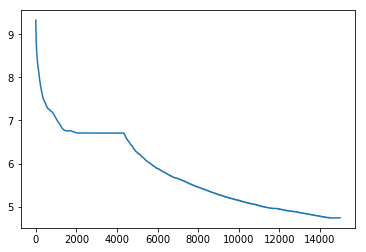

In [153]:
import matplotlib.pyplot as plt
import math
pairs = sorted(word_dict.items(), key=lambda x: x[1], reverse=True)
X = range(1, len(pairs)+1)
Y = [b for a,b in pairs]
Yl = [math.log(x) for x in Y]
plt.plot(X[:15000],Yl[:15000])
plt.show()

In [28]:
save_obj(word_dict, 'word_dict_orig')

SyntaxError: invalid syntax (<ipython-input-70-18481c1de2d3>, line 1)